In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import  keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime



In [12]:
#Load Data
df = pd.read_csv('data/forecasted_master_data.csv')

df['Year'] = pd.to_datetime(df['Year']).dt.year

#Save Data for gradio input
gradio_input = df[df['temp_change'].isna()]
gradio_input.to_csv('test_data_for_gradio.csv', index = False)

#Drop country from data frame
df.drop(columns='Country', axis=1,inplace=True)
#Create a test data from forcasted data frame
test_data = df[df['temp_change'].isna()]

#Create train data
train_data = df[df['temp_change'].notna()]

#Disaply both test and train data shape

display(test_data.shape, train_data.shape)




(1770, 6)

(9680, 6)

In [13]:
#Prapare training data for deep learning modeling 
#Create scaler and scle X_train and test data
scaler = StandardScaler()
scaler.fit(train_data)
train_scaled = pd.DataFrame(scaler.transform(train_data), columns=train_data.columns)

#Scaled test data
test_data_scaled = pd.DataFrame(scaler.transform(test_data), columns=train_data.columns)

X_train = train_scaled.drop(columns='temp_change', axis= 1)
y_train = train_scaled['temp_change']



In [14]:
#Create deep learning model
model = Sequential()
model.add(Dense(128, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [15]:
# Train the model

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])



Epoch 1/1000


242/242 [==============================] - 1s 3ms/step - loss: 0.9580 - mae: 0.7948 - val_loss: 1.0245 - val_mae: 0.7998
Epoch 2/1000
242/242 [==============================] - 1s 2ms/step - loss: 0.9101 - mae: 0.7625 - val_loss: 1.0068 - val_mae: 0.8209
Epoch 3/1000
242/242 [==============================] - 1s 3ms/step - loss: 0.8837 - mae: 0.7425 - val_loss: 0.9853 - val_mae: 0.8141
Epoch 4/1000
242/242 [==============================] - 1s 3ms/step - loss: 0.8624 - mae: 0.7304 - val_loss: 0.8898 - val_mae: 0.7550
Epoch 5/1000
242/242 [==============================] - 1s 2ms/step - loss: 0.8623 - mae: 0.7272 - val_loss: 0.9266 - val_mae: 0.7907
Epoch 6/1000
242/242 [==============================] - 1s 2ms/step - loss: 0.8482 - mae: 0.7191 - val_loss: 0.9141 - val_mae: 0.7583
Epoch 7/1000
242/242 [==============================] - 1s 2ms/step - loss: 0.8396 - mae: 0.7109 - val_loss: 1.0011 - val_mae: 0.7760
Epoch 8/1000
242/242 [==============================] - 1s 2ms/step - loss:

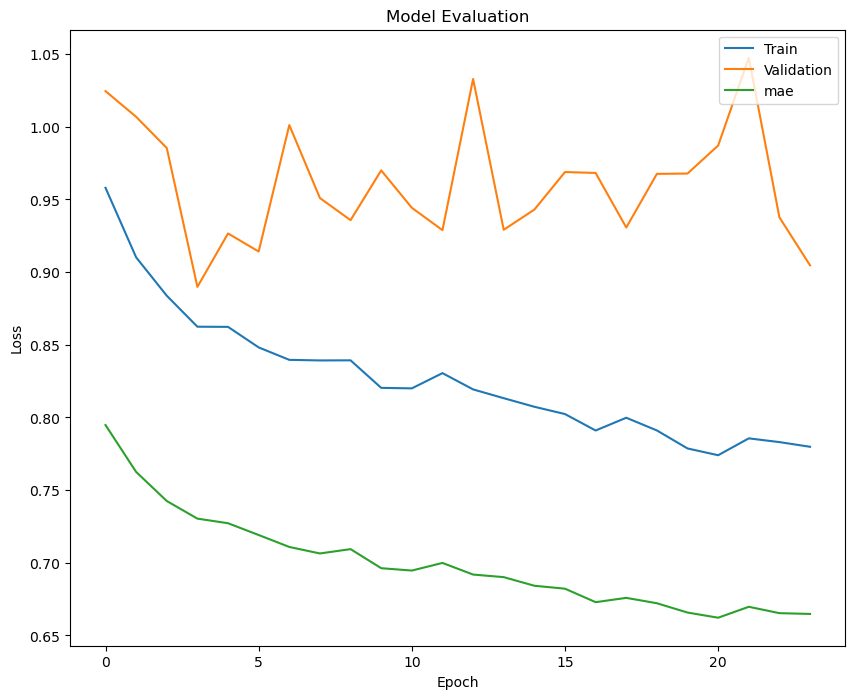

In [16]:
#Plot Model Evaluation values
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['mae'])
plt.title('Model Evaluation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','mae'], loc='upper right')
plt.show()

In [17]:
model.save('Models/emission.h5')

In [18]:
#Predict test data
data_to_predict = test_data_scaled.drop(columns='temp_change', axis=1)

pred_temp_change =  model.predict(data_to_predict)

56/56 [==============================] - 0s 1ms/step


In [19]:
#Combine predicted value to test data
test_data_predicted = df[df['temp_change'].isna()].drop(columns='temp_change', axis = 1)

test_data_predicted['Pred_temp_change'] = pred_temp_change

## Plot Predicted temprature cahnge over years

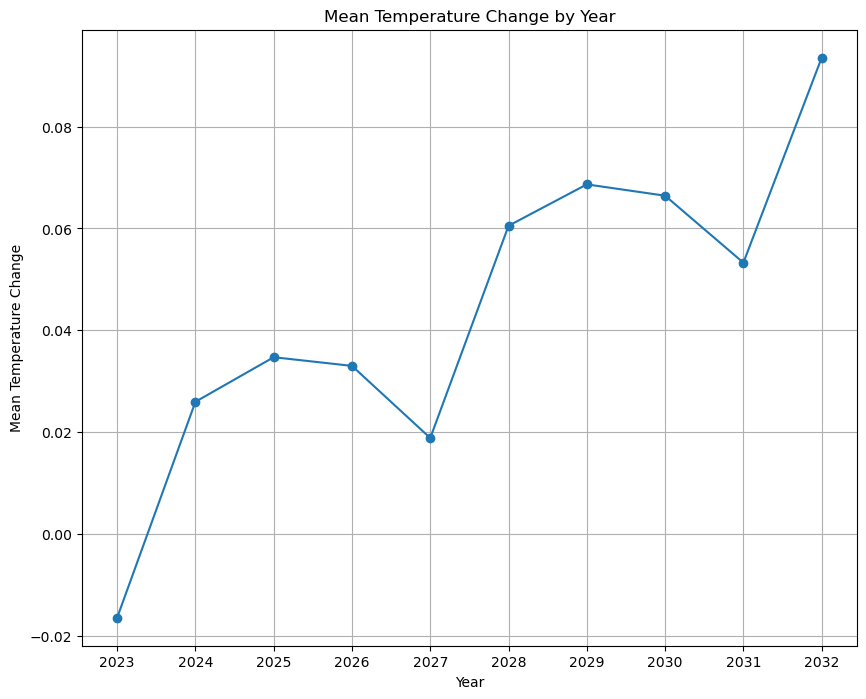

In [20]:

mean_temp_change =test_data_predicted.groupby('Year')['Pred_temp_change'].mean()

# Plotting the data
plt.figure(figsize=(10, 8))
plt.plot(mean_temp_change.index, mean_temp_change.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Mean Temperature Change')
plt.title('Mean Temperature Change by Year')
plt.grid(True)
plt.xticks(mean_temp_change.index)
plt.show()